# Random Optimization Metric Ensemble

This notebook justifies the use of an LLM to select the optimization metric by comparing the results between two groups:
- **Group 1:** The LLM-based ensemble
- **Group 2:** The non LLM-based ensemble with a randomly selected optimization metric

Import packages.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.ticker import FormatStrFormatter
from src.utils.path import resolve_results_path
from tqdm import tqdm

Load group 1's results.

In [5]:
alias_1 = "TSOrchestra"  # LLM-based ensemble with Moirai-2, Sundial, and Toto
all_results_dir = "all_results"
file_name = "all_results.csv"

alias_1_results_path = resolve_results_path() / all_results_dir / alias_1 / file_name
df_1 = pd.read_csv(alias_1_results_path)

# Rename columns to be more descriptive and remove unnecessary columns
df_1 = df_1.rename(
    columns={
        "eval_metrics/MASE[0.5]": "MASE",
        "eval_metrics/mean_weighted_sum_quantile_loss": "CRPS",
    }
)
keep_cols = ["dataset", "model", "MASE", "CRPS", "domain", "num_variates"]
df_1 = df_1[keep_cols]

print(f"Loaded {len(df_1)} rows for {alias_1}")
df_1.head()

Loaded 97 rows for TSOrchestra


,dataset,model,MASE,CRPS,domain,num_variates
0,bitbrains_fast_storage/5T/long,TSOrchestra,0.940343,0.825926,Web/CloudOps,2
1,bitbrains_fast_storage/5T/medium,TSOrchestra,1.023058,0.655812,Web/CloudOps,2
2,bitbrains_fast_storage/5T/short,TSOrchestra,0.700117,0.419518,Web/CloudOps,2
3,bitbrains_fast_storage/H/short,TSOrchestra,1.085526,0.645681,Web/CloudOps,2
4,bitbrains_rnd/5T/long,TSOrchestra,3.393987,0.626281,Web/CloudOps,2


Load group 2's results.

In [6]:
alias_2 = "SLSQPEnsemble_3-models_moirai-sundial-toto_opt-random_1-windows"
all_results_dir = "all_results"
file_name = "all_results.csv"

alias_2_results_path = resolve_results_path() / all_results_dir / alias_2 / file_name
df_2 = pd.read_csv(alias_2_results_path)

# Rename columns to be more descriptive and remove unnecessary columns
df_2 = df_2.rename(
    columns={
        "eval_metrics/MASE[0.5]": "MASE",
        "eval_metrics/mean_weighted_sum_quantile_loss": "CRPS",
    }
)
df_2 = df_2[keep_cols]

print(f"Loaded {len(df_2)} rows for {alias_2}")
df_2.head()

Loaded 48 rows for SLSQPEnsemble_3-models_moirai-sundial-toto_opt-random_1-windows


,dataset,model,MASE,CRPS,domain,num_variates
0,us_births/M/short,SLSQPEnsemble_3-models_moirai-sundial-toto_opt...,0.613907,0.012764,Healthcare,1
1,us_births/W/short,SLSQPEnsemble_3-models_moirai-sundial-toto_opt...,0.901148,0.010871,Healthcare,1
2,us_births/D/short,SLSQPEnsemble_3-models_moirai-sundial-toto_opt...,0.356472,0.018589,Healthcare,1
3,kdd_cup_2018/D/short,SLSQPEnsemble_3-models_moirai-sundial-toto_opt...,1.203035,0.377479,Nature,1
4,kdd_cup_2018/H/short,SLSQPEnsemble_3-models_moirai-sundial-toto_opt...,0.797581,0.342175,Nature,1


Merge the results so we're only comparing datasets that both groups were evaluated on.

In [7]:
suffixes = ["_1", "_2"]
merged_df = pd.merge(
    df_1,
    df_2,
    on=["dataset", "domain", "num_variates"],
    how="inner",
    suffixes=suffixes,
)

# Only keep short-term datasets
merged_df = merged_df[merged_df["dataset"].str.contains("short", case=False)]

print(f"Number of rows: {len(merged_df)}")
merged_df.head()

Number of rows: 48


,dataset,model_1,MASE_1,CRPS_1,domain,num_variates,model_2,MASE_2,CRPS_2
0,bitbrains_fast_storage/H/short,TSOrchestra,1.085526,0.645681,Web/CloudOps,2,SLSQPEnsemble_3-models_moirai-sundial-toto_opt...,1.001568,0.547587
1,bitbrains_rnd/5T/short,TSOrchestra,1.670797,0.398734,Web/CloudOps,2,SLSQPEnsemble_3-models_moirai-sundial-toto_opt...,1.651169,0.377719
2,bitbrains_rnd/H/short,TSOrchestra,5.871847,0.664922,Web/CloudOps,2,SLSQPEnsemble_3-models_moirai-sundial-toto_opt...,5.825690,0.633505
3,bizitobs_application/10S/short,TSOrchestra,1.359036,0.013357,Web/CloudOps,2,SLSQPEnsemble_3-models_moirai-sundial-toto_opt...,1.198885,0.011439
4,bizitobs_l2c/5T/short,TSOrchestra,0.248710,0.067188,Web/CloudOps,7,SLSQPEnsemble_3-models_moirai-sundial-toto_opt...,0.245379,0.065468


Compute summary statistics to compare group 1 and group 2's performance.

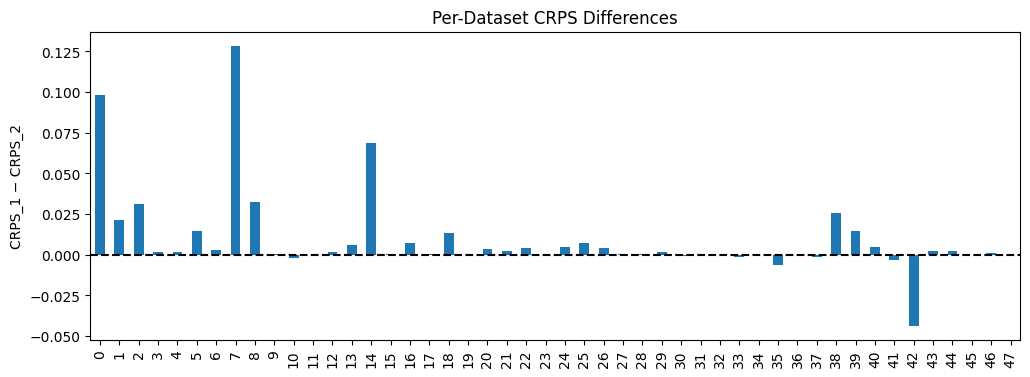

In [11]:
metric = "CRPS"

merged_df[f"{metric}_diff"] = merged_df[f"{metric}_1"] - merged_df[f"{metric}_2"]

merged_df[f"{metric}_diff"].plot(kind="bar", figsize=(12, 4))
plt.axhline(0, color="black", linestyle="--")
plt.ylabel(f"{metric}_1 − {metric}_2")
plt.title(f"Per-Dataset {metric} Differences")
plt.show()